This file is used to produce Fig 3.2

Energy.xlsx file contains dataset. It is available through the link: https://archive-beta.ics.uci.edu/dataset/242/energy+efficiency

Reference: Tsanas,Athanasios & Xifara,Angeliki. (2012). Energy efficiency. UCI Machine Learning Repository.

In [ ]:
# loading packages
import numpy as np
import pandas as pd
from sklearn import preprocessing
import scipy
from numpy import linalg as LA
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
# Global Varaible
Monte = 2                   #Monte-Carlo Simulation Numbers
m,d=(768,8)                 #Data dimension
(dim_G,dim_P) = (9,9)       #Subspace Dimension
width = 1.2                 #Gaussian Kernel Width
m_t = 500                   #Training Set Size
m_e = 268                   #Testing Set Size
index = range(0,m_t)        #Index used for train-test split

In [13]:
# Optimal Recovery Map
def OR(Input_1,Kern_inv,Y_train,Input_2,Cross_kern):
    Output_1 = Y_train
    C = LA.inv(LA.multi_dot([np.transpose(Input_1),Kern_inv,Input_1]))
    Co_1 = LA.multi_dot([C,np.transpose(Input_1),Kern_inv,Output_1])
    Co_2 = LA.multi_dot([Kern_inv,(Output_1 - np.dot(Input_1,Co_1))])
    return np.dot(Input_2,Co_1) + np.dot(Cross_kern,Co_2)

In [14]:
Er_KRR_GNG = np.zeros(shape = (Monte,1))
Error_Taylor_reg = np.zeros(shape = (dim_G,Monte))
Error_GNG = np.zeros(shape = (dim_G,Monte))

In [15]:
# Monte Code
for k in range(0,Monte):
    Data = pd.read_excel('Energy.xlsx')                     #Reading data, should be customized to read new data file.
    Data = pd.DataFrame(preprocessing.scale(Data))
    Data = Data.sort_values(by = [5])                       #Sorting data, should be customized to sort the data according to a different attributed.
    Dat = Data.to_numpy()
    Y = Dat[:,0]
    X = np.delete(Dat,0,axis = 1)
    D = distance.squareform(distance.pdist(X,'euclidean'))
    Kern_Gauss = np.exp(-D**2/(2*width**2))
    Kern_Gauss_inv = LA.inv(Kern_Gauss)
    Ex = np.zeros(shape = (m,1))
    for i in range(0,m):
        Ex = np.exp(-LA.norm(X[i,:])**2/(2*width**2))
    L= (1/width)*Ex*X
    X_Taylor = np.hstack((Ex*np.ones(shape = (m,1)),L))
    (X_train,X_test)=(X[index,:],np.delete(X,index,0))
    (X_Taylor_train,X_Taylor_test)=(X_Taylor[index,:],np.delete(X_Taylor,index,0))
    (Y_train,Y_test)=(Y[index],np.delete(Y,index,0))
    D_train = distance.squareform(distance.pdist(X_train,'euclidean'))
    Kern_Gauss_train = np.exp(-D_train**2/(2*width**2))
    Kern_Gauss_train_inv = LA.inv(Kern_Gauss_train)
    CrossKern_Gauss = np.zeros(shape = (m_e,m_t))
    for i in range(0,m_e):
        for j in range(0,m_t):
            CrossKern_Gauss[i,j] = np.exp(-distance.euclidean(X_test[i],X_train[j])**2/(2*width**2))
    for i in range(0,dim_G):
        Error_GNG[i,k] = LA.norm(OR(X_Taylor_train[:,0:i],Kern_Gauss_train_inv,Y_train,X_Taylor_test[:,0:i],CrossKern_Gauss) - Y_test,ord = 2)/m_e
    Y_hat = LA.multi_dot([CrossKern_Gauss,Kern_Gauss_train_inv,Y_train])    
    Er_KRR_GNG[k] = LA.norm(Y_hat - Y_test,ord = 2)/m_e
    for i in range(0,dim_G):
        Error_Taylor_reg[i,k] = LA.norm(Y_test - LA.multi_dot([X_Taylor_test[:,0:i],LA.inv(np.dot(np.transpose(X_Taylor_train[:,0:i]),X_Taylor_train[:,0:i])),np.transpose(X_Taylor_train[:,0:i]),Y_train])  , ord = 2)/m_e           


In [16]:
#%%Average OR Error
Error_GNG_avg = np.zeros(shape = (dim_G,1))
Error_GNG_ste = np.zeros(shape = (dim_G,1))
for i in range(0,dim_G):
    Error_GNG_avg[i] = np.mean(Error_GNG[i,:])
for i in range(0,dim_G):
    Error_GNG_ste[i] = np.std(Error_GNG[i,:])/Monte



In [17]:
#%%Average Taylor Regression Error
Error_Taylor_avg = np.zeros(shape = (dim_G,1))
Error_Taylor_ste = np.zeros(shape = (dim_G,1))
for i in range(0,dim_G):
    Error_Taylor_avg[i] = np.mean(Error_Taylor_reg[i,:])
    
for i in range(0,dim_G):
    Error_Taylor_ste[i] = np.std(Error_Taylor_reg[i,:])/Monte

In [18]:
#%%Average Kernel Ridgeless Regression
Er_KRR_avg = np.mean(Er_KRR_GNG)*np.ones(shape = (dim_G,1))
Er_KRR_ste = np.std(Er_KRR_GNG)/Monte*np.ones(shape = (dim_G,1))

In [19]:
#%%Output
print(Error_GNG)            #The L-2 norm of the test error vector for Optimal Recovery. A dim(dim_G,Monte) array. Row i corresponds to Optimal Recovery error with subspace V of dimension i+1 for Monte number of simulations.
print(Error_Taylor_reg)     #The L-2 norm of the test error vector for Taylor feature regression. A dim(dim_G,Monte) array. Row i corresponds to Taylor feature regression error with space V of dimension i+1 for Monte number of simulations.
print(Er_KRR_GNG)           #The L-2 norm of the test error vector for Gaussian kernel ridgeless regression. A dim(Monte,1) array. When the full dataset is being used, Monte = 1, this output become a number.

[[0.01255351 0.01255351]
 [0.01244876 0.01244876]
 [0.00198465 0.00198465]
 [0.00205688 0.00205688]
 [0.0048847  0.0048847 ]
 [0.00143924 0.00143924]
 [0.0038839  0.0038839 ]
 [0.00247106 0.00247106]
 [0.00231194 0.00231194]]
[[0.06112879 0.06112879]
 [0.06113386 0.06113386]
 [0.00771449 0.00771449]
 [0.00769318 0.00769318]
 [0.00771975 0.00771975]
 [0.0059553  0.0059553 ]
 [0.00597381 0.00597381]
 [0.00603938 0.00603938]
 [0.00603608 0.00603608]]
[[0.01255351]
 [0.01255351]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


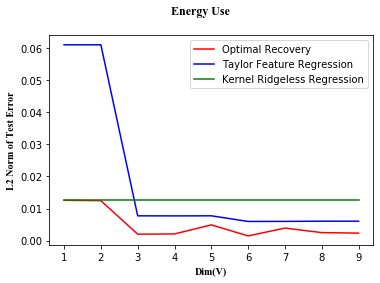

In [20]:
#%%Plot
Xlabel = range(1,10)
plt.plot(Xlabel,Error_GNG_avg,color='red',label = 'Optimal Recovery')
plt.plot(Xlabel,Error_Taylor_avg, color='blue',label = 'Taylor Feature Regression')
plt.plot(Xlabel,Er_KRR_avg,color = 'green',label = 'Kernel Ridgeless Regression')
plt.ylabel('L2 Norm of Test Error',fontname="Times New Roman")
plt.xlabel('Dim(V)',fontname="Times New Roman")
plt.suptitle('Energy Use',fontname="Times New Roman")
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15,left = 0.15)
plt.savefig("Energy_Taylor.eps",format = 'eps') 